In [1]:
import numpy as np
from matplotlib import pyplot as plt

<h2>Demonstration of a hadamard gate on single qubit</h2>
<img src='resources/nate/single_hadamard.png' width="200"/>

The hadamard is represented as a 2x2 matrix operator $\frac{1}{\sqrt(2)} \begin{bmatrix}1&1\\1&-1 \end{bmatrix}$

A qubit is provided, initialized at state $\ket{\psi} = \ket{0}$
Hadamard is applied on the qubit, throwing it into superposition $\frac{\ket{0}+\ket{1}}{\sqrt{2}}$

A measurement is then taken, collapsing the qubit to either state $\ket{0} = \begin{bmatrix} 1 \\ 0\end{bmatrix}$ or $\ket{1} = \begin{bmatrix}0\\1\end{bmatrix}$ with probability $|\frac{1}{\sqrt{2}}|^{2} = 0.5$ for both states.

This measurement is represented as matrix multiplication by $\ket{0}\bra{0} = \begin{bmatrix} 1 & 0 \\ 0 & 0\end{bmatrix}$ or $\ket{1}\bra{1} = \begin{bmatrix} 0 & 0 \\ 0 & 1\end{bmatrix}$

In [2]:
# Define computational basis states
zero = np.array([1, 0], dtype=complex)
one = np.array([0, 1], dtype=complex)

In [3]:
#define some operators and gates

#hadamard gate for n qubits
def hadamard(n):
    #define hadamard h
    h = np.array([[1,1],[1,-1]], dtype=complex)/np.sqrt(2)
    #n-generalized hadamard
    H = h
    #find hadamard tensor product for n qubits
    for _ in range(n-1):
        H = np.kron(H, h)
    return H
    
def measure(qbit, count):
    #define probability array for collapses
    probs = (np.abs(qbit)**2).flatten()
    print(probs)
    #define measurement operators
    #m1 = np.array([[1,0],[0,0]], dtype=complex)
    #m2 = np.array([[0,0],[0,1]], dtype=complex)
    #simulate count measurements
    measurements = np.random.choice([0,1], p=probs, size=count)
    return measurements

def normalize(qbit):
    norm = np.linalg.norm(qbit)
    norm = 1 if norm == 0 else norm
    normed = qbit / norm
    return normed

#demonstrate effect of single hadamard gate and measurement
def run_single_hadamard(qbits, shots):
    measured = np.array([])
    for qbit in qbits:
        appliedH = hadamard(1) @ qbit
        measured = measure(appliedH, shots)
        print("Input: ",qbit.T, "Superposition: ", appliedH.T, "Measurement: ", measured.T[0]) #print horiz for better viewing
    return measured
    
#demonstrate double hadamard and measurement
def run_double_hadamard(qbits, shots):
    measured = np.array([])
    for qbit in qbits:
        appliedH = hadamard(1) @ qbit
        appliedH2 = hadamard(1) @ appliedH
        measured = measure(appliedH2, shots)
        print("Input: ",qbit.T, "Superposition: ", appliedH.T, "Measurement: ", measured.T[0])
    return measured

In [4]:
#plot results in a bar chart
def plot(measurements):
    #preplot data
    count0 = np.sum(measurements == 0)
    count1 = np.sum(measurements == 1)
    total = count0 + count1
    percent0 = f"{round(count0/total*100, 2)}%"
    percent1 = f"{round(count1/total*100, 2)}%"
    #plots
    plt.bar(['0','1'], [count0, count1], color=['red', 'blue'], label=[percent0, percent1])
    plt.xlabel("Measurement")
    plt.ylabel("Count")
    plt.legend()
    plt.title("Circuit measurements")
    plt.show()

[0.5 0.5]
Input:  [[0 1]] Superposition:  [[ 0.70710678+0.j -0.70710678+0.j]] Measurement:  0
[0. 1.]
Input:  [[0 1]] Superposition:  [[ 0.70710678+0.j -0.70710678+0.j]] Measurement:  1


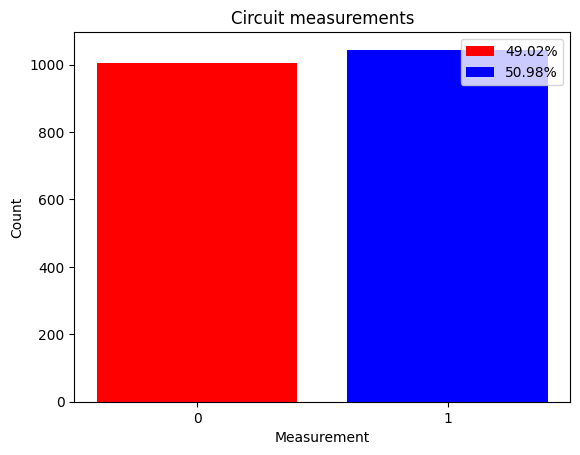

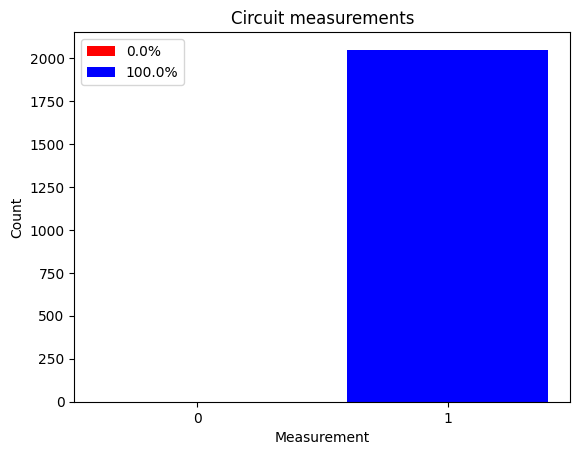

In [5]:
#model qubits as 2x1 array
q0 = np.array([[1],[0]]) #initialized to |0)
q1 = np.array([[0],[1]]) #init to |1)
singleHOutput = run_single_hadamard([q1], 2048)
doubleHOutput = run_double_hadamard([q1], 2048)

#plot outputs
plot(singleHOutput)
plot(doubleHOutput)

**Entanglement**
The following example serves to show how a few qubits with an entangled state share a wavefunction and thus have correlated outcomes when measuremed

We take three input qubits, superposition one via a Hadamard gate, and entangle them via Controlled-NOT (CNOT) gates.

We represent the CNOT gate as a 4x4 matrix:

CNOT = $ \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{bmatrix} $

<img src='resources/nate/entangled.png' width="200"/>

In [6]:
'''
Tensor helper
Usage: kron(one, one, zero) gives |110) basis vector
'''
def kron(*args):
    result = np.array([1], dtype=complex)
    for a in args:
        result = np.kron(result, a)
    return result

In [7]:
'''
Routine to get the spanning basis vectors of a C^n hilbert space
for n qubits
WARNING: by nature of the tensor product, the output space will have 2^n bases!
'''
def get_hilbert_basis(num_qubits):
    #define states array for holding bases
    bases = [zero, one] #set to single qubit by default
    #define bases list for holding states between calculation
    states = np.array([], dtype=complex)

    if num_qubits<=0:
        print("At least one qubit required")
        return;
    for _ in range(num_qubits - 1):
        for b in bases:
            #perform tensor product with |0) and |1) states
            states = np.append(states, [np.kron(b, [1,0])])
            states = np.append(states, [np.kron(b, [0,1])])
        bases = states
        states = np.array([], dtype=complex)
    #reshape for distinct basis lists
    bases = bases.reshape(2**num_qubits, 2**num_qubits)
    return bases

In [8]:
def cnot_gate(n, control_q, target_q):
    I = np.eye(2, dtype=complex)
    X = np.array([[0,1],
                  [1,0]], dtype=complex)
    P0 = np.array([[1, 0],
                   [0, 0]], dtype=complex)
    P1 = np.array([[0, 0],
                   [0, 1]], dtype=complex)
    
    #operations for generalized cnot
    ops = []
    for i in range(n):
        if i == control_q:
            ops.append((P0, P1))
        elif i == target_q:
            ops.append((I, X))
        else:
            ops.append((I, I))
    
    term0 = ops[0][0]
    term1 = ops[0][1]
    for i in range(1, n):
        term0 = np.kron(term0, ops[i][0])
        term1 = np.kron(term1, ops[i][1])

    return term0 + term1

In [9]:
'''
Routine to entangle input qubits using hadamard and CNOT
Takes input state |Ψ), applies hadamard to first qubit
Applies CNOT across next qubits in array
'''
def entangle(*qubits):
    num_q = len(qubits) #number of input qubits
    #apply hadamard to first qubit
    qubits[0] = hadamard(num_q) @ qubits[0]
    #successively apply CNOT
    for _ in  range(1, num_q - 1):
        qubits[i] = cnot_gate(num_q, control_q=0, target_q=i) @ qubits[i]
    return qubits

    
**Look up how we can write python code to apply an arbitrary operator on a qubit**

def apply_operator(o, psi, qubit):

    return new_wavefunction

Find a way to represent quantum entanglement and quantum teleportation